# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost
## Name: Sarah Jones
## Due: 9/28/2021

### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil. 


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s, 

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve, 

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020. 

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature. 

Yur __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3] 

dt = 0.25 # Time step [day] => 0.25*1 day = 6 hour increments

#### 2.1 Load and Plot the Air Temperature Trends

In [2]:
# Load data
data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0]   # Loads time data (year from 2020 to 2100)
T_15 = data[:,1]   # Loads temp data for scenario 1, 1.5 degree increase in temperature
T_30 = data[:,2]   # Loads temp data for scenario 2, 3.0 degree increase in temperature
T_45 = data[:,3]   # Loads temp data for scenario 3, 4.5 degree increase in temperature

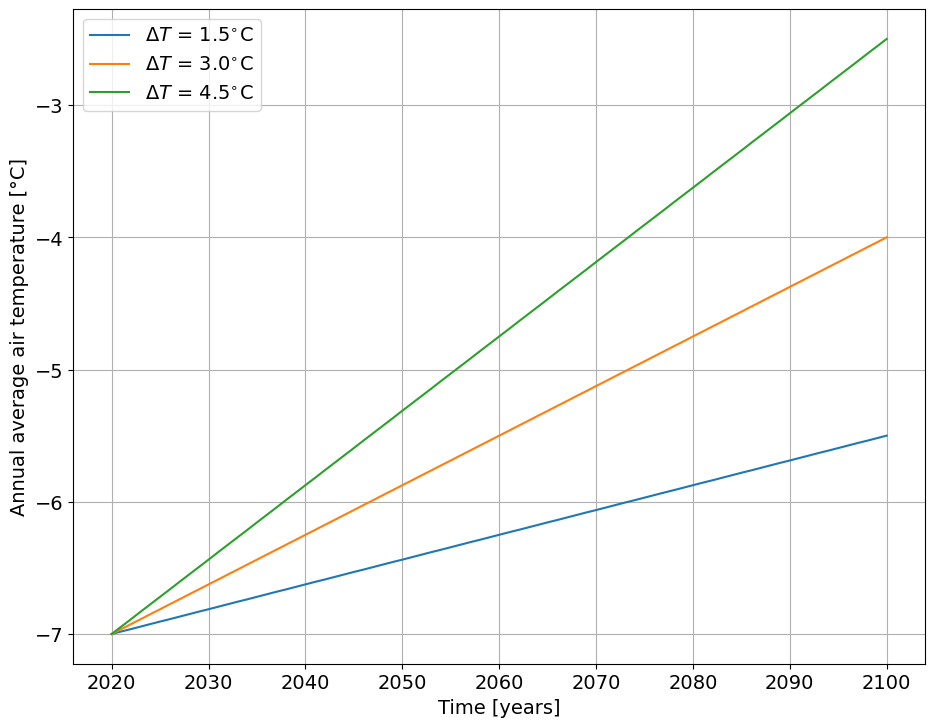

In [3]:
# Plot air temperature data
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

plt.show()

#### 2.2 Setup the Simulation Time Period

In [4]:
# Setup initial conditions for time
t0 = t_year[0]   # t0 = 2020
tf = t_year[-1]  # tf = 2100

# Create vector of time data
t = np.arange(t0,tf+(dt/365),(dt/365))   # dt * (1 year)/(365 days) which converts units 
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  116801


### 3. Setup Boundary Conditions

In [5]:
# Boundary conditions
Ttopamp = 35.0   # Amplitude of temperature sinusoidal fluctuation, Degrees C
Tbottom = -7.0   # Constant temperature at bottom of soil column, Degrees C

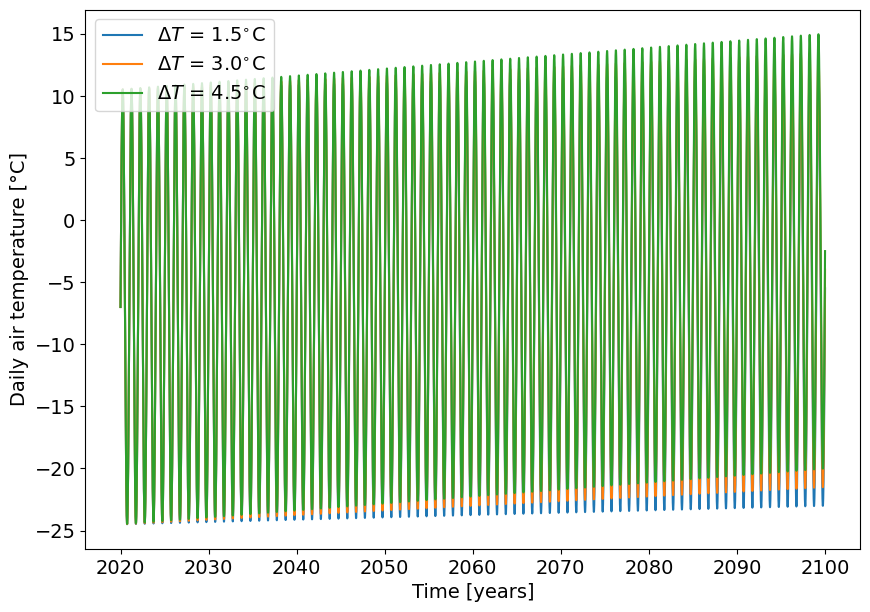

In [6]:
# Create temperature sinusoidal forcing term based on the interpolated provided data for each scenario.
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

# Plot soil temperature data for each scenario
plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

### 4. Setup Spatial Domain

In [7]:
# Define soil layers
z = np.arange(dz/2, zs, dz)
Nz = z.size
print('Here are the locations of our cells: z = \n' + str(z))
print('The number of cells is: Nz = ',str(Nz))

Here are the locations of our cells: z = 
[  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5 127.5 142.5 157.5 172.5
 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5
 367.5 382.5 397.5 412.5 427.5 442.5 457.5 472.5 487.5]
The number of cells is: Nz =  33


### 5. Setup Initial Condition

In [8]:
# Calculate diffusivity of permafrost soil
alpha = ks / (rhos * Cs)    # alpha corresponds to D_s in the equations defined in intro section
print('Soil diffusivity = '+str(alpha)+' m^2/s')

# Convert alpha to units consistent with domain [cm^2/day]
alpha = alpha*(100.0**2)*(24.0*3600.0)   
print('Soil diffusivity = '+str(alpha)+' cm^2/day')

s = alpha*dt/(dz**2)   # Corresponds to the last equation in the intro section
print('Stability criterion '+str(s))

# Define initial temperature column vector
Ts0 = Tbottom*np.ones((Nz,1))

Soil diffusivity = 4.279356384799726e-07 m^2/s
Soil diffusivity = 369.7363916466963 cm^2/day
Stability criterion 0.41081821294077364


### 6. (UNUSED - Explicit Method was used for Solution, see Section 8)

### 7. Preallocate Storage Memory

In [9]:
# Initiates empty matrices of desired size in which values will be stored after calculation
Ts_15 = np.zeros((Nz,Nt))
Ts_30 = np.zeros((Nz,Nt))
Ts_45 = np.zeros((Nz,Nt))

### 8. Apply Solution And Compute Temperatures

In [10]:
for i in np.arange(Nt):   # rows are time step
    for j in np.arange(Nz):   # columns are depth in soil
        # rows will represent temperature profiles in soil at a specific time step
        
        # Calculate temperature values for specified conditions
        if(i==0):                       # Sets conditions for when i = 0 
            if(j==0):                     # Sets conditions at surface boundary
                # Sets initial temperature value for previous soil layer, z-1
                T0zm1_15 = Ttop_15[i]     
                T0zm1_30 = Ttop_30[i]     
                T0zm1_45 = Ttop_45[i]
                
                # Sets initial temperature value for current soil layer, z
                T0z_15   = Ts0[j]       
                T0z_30   = Ts0[j]
                T0z_45   = Ts0[j]
                
                # Sets initial temperature value for next soil layer, z+1
                T0zp1_15 = Ts0[j+1]       
                T0zp1_30 = Ts0[j+1]
                T0zp1_45 = Ts0[j+1]
                
            elif((j>0) and (j<(Nz-1))):   # Sets conditions for soil layers between boundaries
                # Sets initial temperature value for previous soil layer, z-1
                T0zm1_15 = Ts0[j-1]
                T0zm1_30 = Ts0[j-1]
                T0zm1_45 = Ts0[j-1]
                
                # Sets initial temperature value for current soil layer, z
                T0z_15   = Ts0[j]
                T0z_30   = Ts0[j]
                T0z_45   = Ts0[j]
                
                # Sets initial temperature value for next soil layer, z+1
                T0zp1_15 = Ts0[j+1]
                T0zp1_30 = Ts0[j+1]
                T0zp1_45 = Ts0[j+1]
                
            elif(j==(Nz-1)):             # Sets conditions at bottom boundary
                # Sets initial temperature value for previous soil layer, z-1
                T0zm1_15 = Ts0[j-1]
                T0zm1_30 = Ts0[j-1]
                T0zm1_45 = Ts0[j-1]
                
                # Sets initial temperature value for current soil layer, z
                T0z_15   = Ts0[j]
                T0z_30   = Ts0[j]
                T0z_45   = Ts0[j]
                
                # Sets initial temperature value for next soil layer, z+1
                T0zp1_15 = Tbottom
                T0zp1_30 = Tbottom
                T0zp1_45 = Tbottom
        else:                         # Sets conditions for all other i values
            if(j==0):                   # Sets conditions at surface boundary
                # Sets temperature value for previous soil layer, z-1
                T0zm1_15 = Ttop_15[i]
                T0zm1_30 = Ttop_30[i]
                T0zm1_45 = Ttop_45[i]
                
                # Sets temperature value for current soil layer, z
                T0z_15   = Ts_15[j,i-1]
                T0z_30   = Ts_30[j,i-1]
                T0z_45   = Ts_45[j,i-1]
                
                # Sets temperature value for next soil layer, z+1
                T0zp1_15 = Ts_15[j+1,i-1]
                T0zp1_30 = Ts_30[j+1,i-1]
                T0zp1_45 = Ts_45[j+1,i-1]
                
            elif((j>0) and (j<(Nz-1))): # Sets conditions for soil layers between boundaries
                # Sets temperature value for previous soil layer, z-1
                T0zm1_15 = Ts_15[j-1,i-1]
                T0zm1_30 = Ts_30[j-1,i-1]
                T0zm1_45 = Ts_45[j-1,i-1]
                
                # Sets temperature value for current soil layer, z
                T0z_15   = Ts_15[j,i-1]
                T0z_30   = Ts_30[j,i-1]
                T0z_45   = Ts_45[j,i-1]
                
                # Sets temperature value for next soil layer, z+1
                T0zp1_15 = Ts_15[j+1,i-1]
                T0zp1_30 = Ts_30[j+1,i-1]
                T0zp1_45 = Ts_45[j+1,i-1]
                
            elif(j==(Nz-1)):            # Sets conditions at bottom boundary
                # Sets temperature value for previous soil layer, z-1
                T0zm1_15 = Ts_15[j-1,i-1]
                T0zm1_30 = Ts_30[j-1,i-1]
                T0zm1_45 = Ts_45[j-1,i-1]
                
                # Sets temperature value for current soil layer, z
                T0z_15   = Ts_15[j,i-1]
                T0z_30   = Ts_30[j,i-1]
                T0z_45   = Ts_45[j,i-1]
                
                # Sets temperature value for next soil layer, z+1
                T0zp1_15 = Tbottom
                T0zp1_30 = Tbottom
                T0zp1_45 = Tbottom
        
        # Calculates the temperature for the soil layer
        Tz_15 = s*T0zm1_15 + (1.0 - 2.0*s)*T0z_15 + s*T0zp1_15
        Tz_30 = s*T0zm1_30 + (1.0 - 2.0*s)*T0z_30 + s*T0zp1_30
        Tz_45 = s*T0zm1_45 + (1.0 - 2.0*s)*T0z_45 + s*T0zp1_45
        
        # Records calculated temperature data and associated time step in Ts matrix.
        # j is the temperature in the soil layer, i is the associated time step.
        Ts_15[j,i] = Tz_15
        Ts_30[j,i] = Tz_30
        Ts_45[j,i] = Tz_45

### 9. Plot Results, Analyze, and Interpret

Create plots of the following:

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.
2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm. 
3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

#### 9.1 Plot

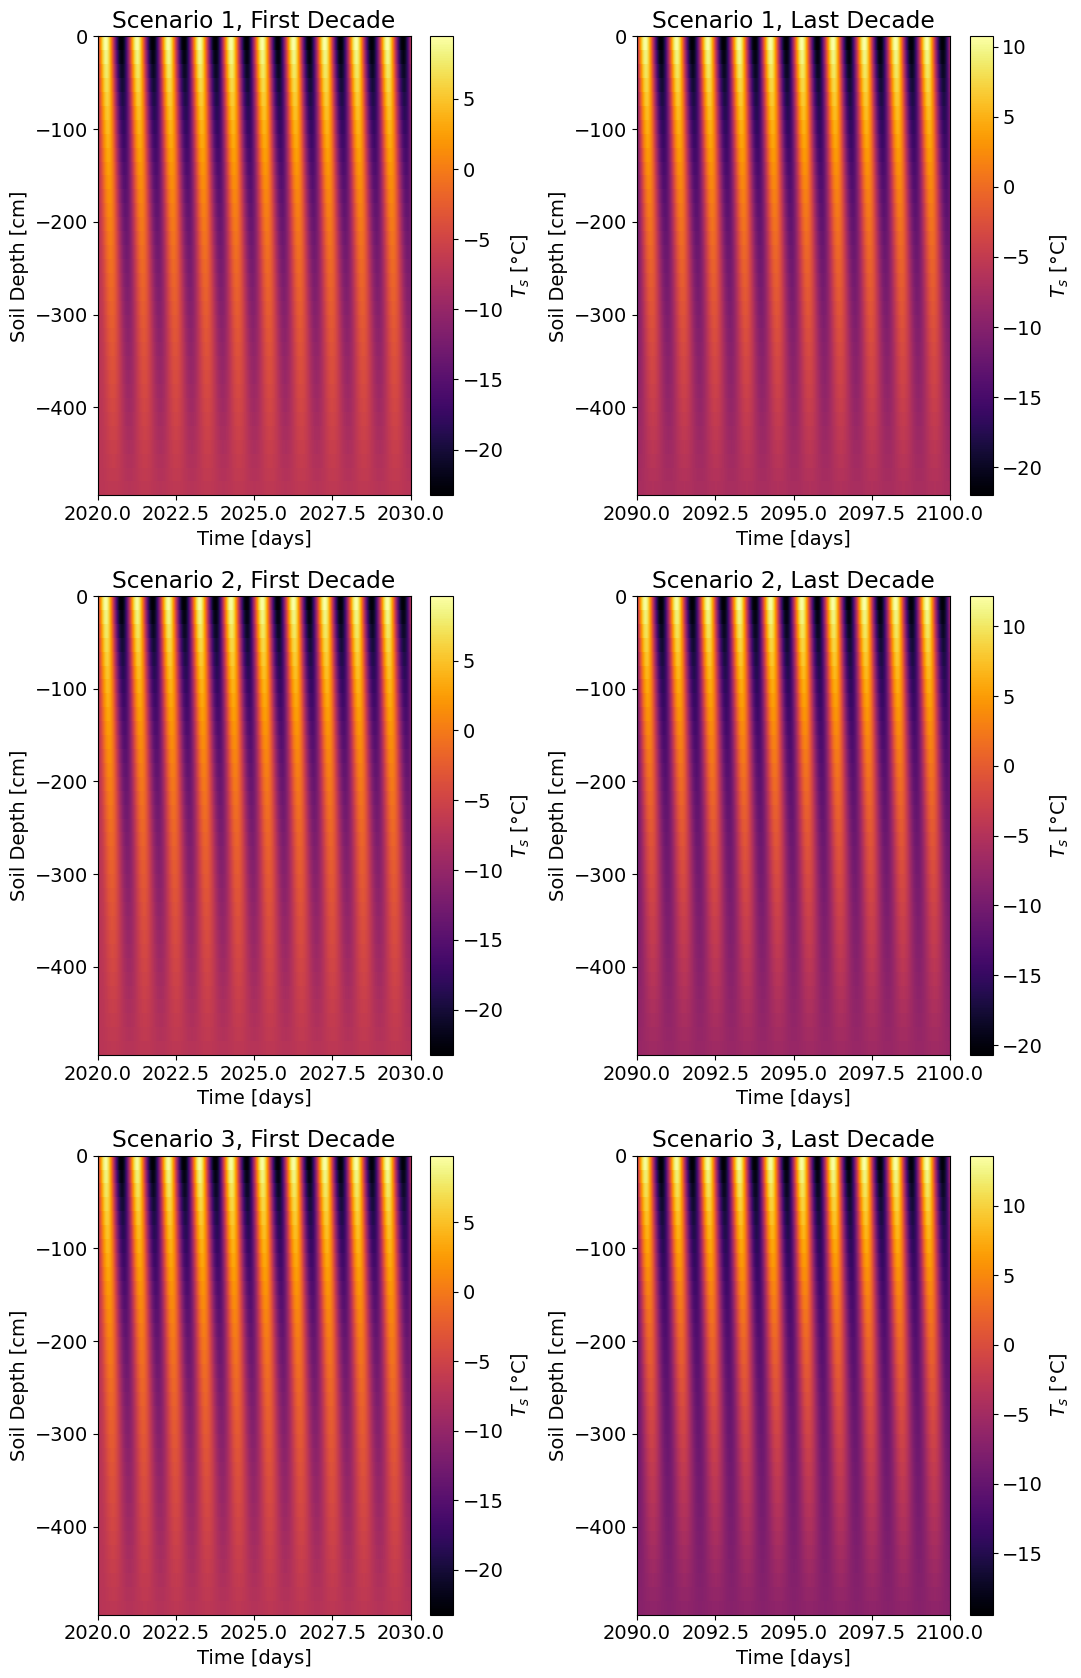

In [11]:
# Plot temperature distribution in soil for each scenario (rows), and the first and last decades (columns)

# Define t indices for desired time frames: 2020-2030 & 2090-2100
t_i10 = t[0:14601]
t_f10 = t[102200:Nt+1]

# Plot results
plt.figure(figsize = (11,17))
plt.rcParams.update({'font.size': 14})

# Create meshgrid of data for desired decade for plotting
t1,z1 = np.meshgrid(t_i10,z)
t2,z2 = np.meshgrid(t_f10,z)

# Scenario 1, 2020-2030
plt.subplot(3,2,1)
plt.pcolormesh(t1,-z1,Ts_15[:,0:14601], cmap='inferno',shading='auto')
plt.colorbar(label= '$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil Depth [cm]')
plt.title('Scenario 1, First Decade')

# Scenario 1, 2090-2100
plt.subplot(3,2,2)
plt.pcolormesh(t2,-z2,Ts_15[:,102200:Nt+1], cmap='inferno',shading='auto')
plt.colorbar(label= '$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil Depth [cm]')
plt.title('Scenario 1, Last Decade')

# Scenario 2, 2020-2030
plt.subplot(3,2,3)
plt.pcolormesh(t1,-z1,Ts_30[:,0:14601], cmap='inferno',shading='auto')
plt.colorbar(label= '$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil Depth [cm]')
plt.title('Scenario 2, First Decade')

# Scenario 2, 2090-2100
plt.subplot(3,2,4)
plt.pcolormesh(t2,-z2,Ts_30[:,102200:Nt+1], cmap='inferno',shading='auto')
plt.colorbar(label= '$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil Depth [cm]')
plt.title('Scenario 2, Last Decade')

# Scenario 3, 2020-2030
plt.subplot(3,2,5)
plt.pcolormesh(t1,-z1,Ts_45[:,0:14601], cmap='inferno',shading='auto')
plt.colorbar(label= '$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil Depth [cm]')
plt.title('Scenario 3, First Decade')

# Scenario 3, 2090-2100
plt.subplot(3,2,6)
plt.pcolormesh(t2,-z2,Ts_45[:,102200:Nt+1], cmap='inferno',shading='auto')
plt.colorbar(label= '$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil Depth [cm]')
plt.title('Scenario 3, Last Decade')

plt.tight_layout()
plt.show()

#### 9.2 Plot

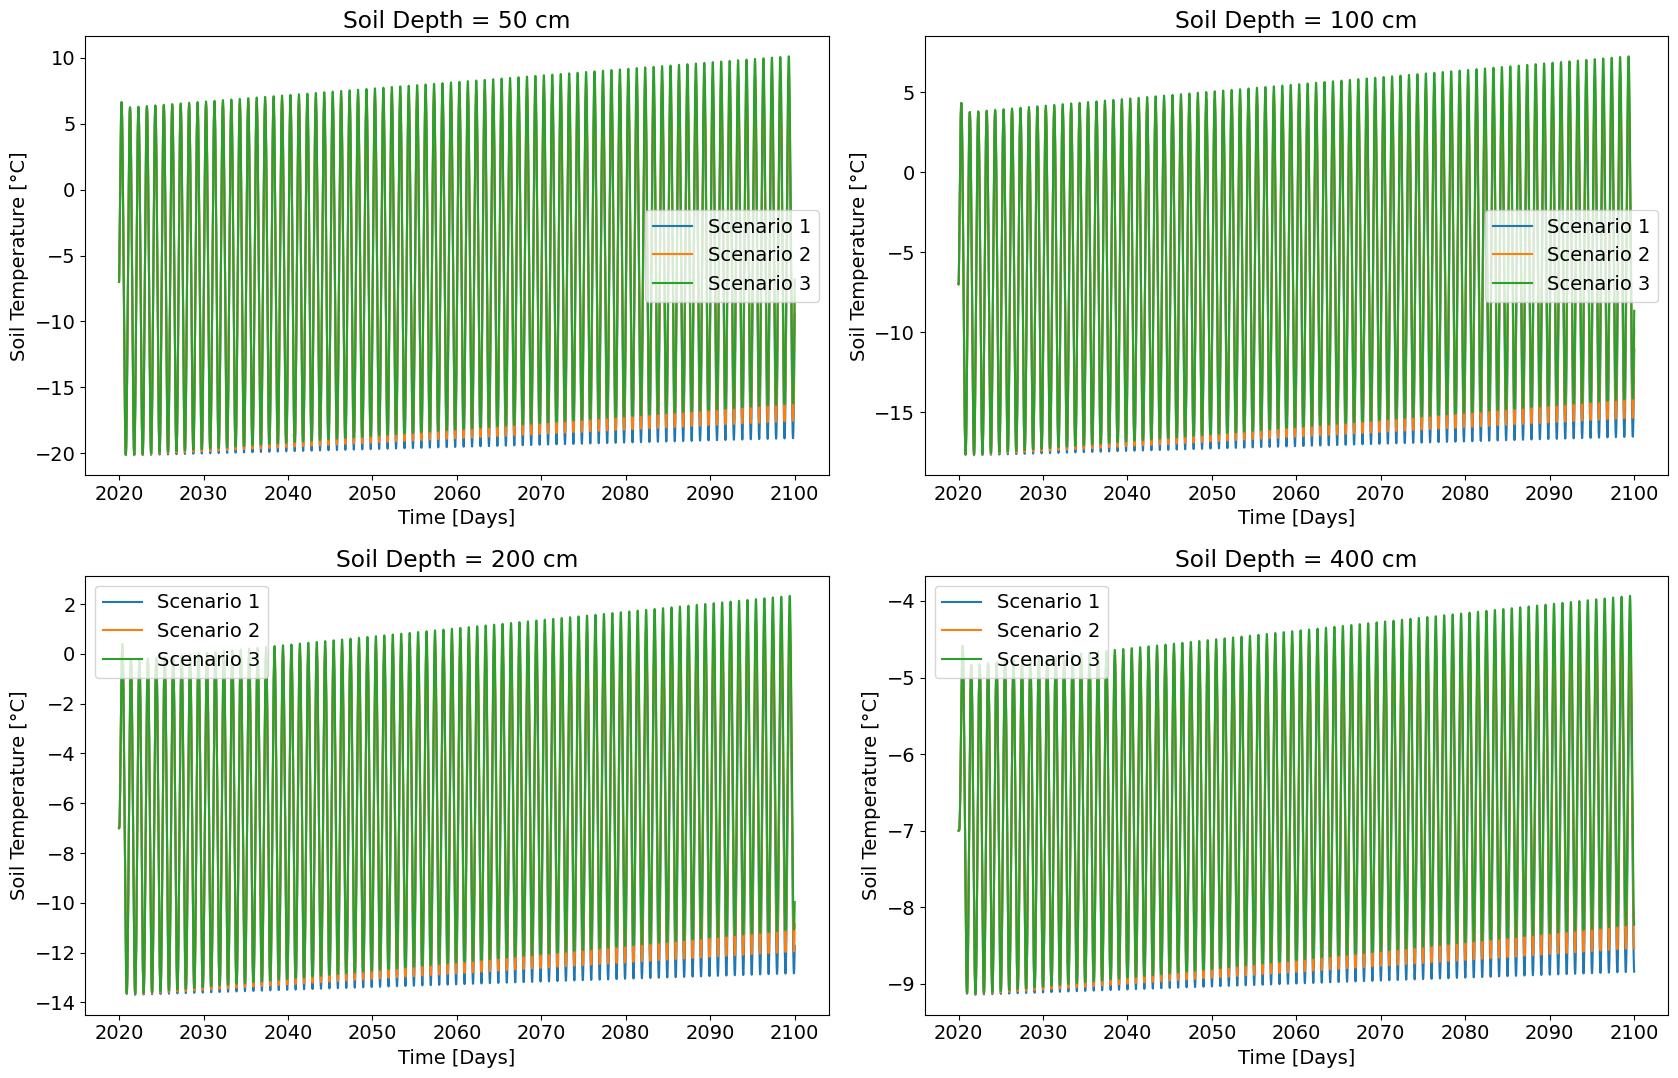

In [12]:
# Plot soil temperature at 4 specific soil layers (50 cm, 100 cm, 200 cm, 400 cm) with all three scenarios
# on the same plot

plt.figure(figsize = (17,11))
plt.rcParams.update({'font.size': 14})

# Isolate soil layer of interest
iz50 = (np.absolute(z-50.0)).argmin()
iz100 = (np.absolute(z-100.0)).argmin()
iz200 = (np.absolute(z-200.0)).argmin()
iz400 = (np.absolute(z-400.0)).argmin()

# Soil depth = 50 cm
plt.subplot(2,2,1)
plt.plot(t,Ts_15[iz50,:],label='Scenario 1')
plt.plot(t,Ts_30[iz50,:],label='Scenario 2')
plt.plot(t,Ts_45[iz50,:],label='Scenario 3')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.title('Soil Depth = 50 cm')
plt.legend()

# Soil depth = 100 cm
plt.subplot(2,2,2)
plt.plot(t,Ts_15[iz100,:],label='Scenario 1')
plt.plot(t,Ts_30[iz100,:],label='Scenario 2')
plt.plot(t,Ts_45[iz100,:],label='Scenario 3')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.title('Soil Depth = 100 cm')
plt.legend()

# Soil depth = 200 cm
plt.subplot(2,2,3)
plt.plot(t,Ts_15[iz200,:],label='Scenario 1')
plt.plot(t,Ts_30[iz200,:],label='Scenario 2')
plt.plot(t,Ts_45[iz200,:],label='Scenario 3')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.title('Soil Depth = 200 cm')
plt.legend()

# Soil depth = 400 cm
plt.subplot(2,2,4)
plt.plot(t,Ts_15[iz400,:],label='Scenario 1')
plt.plot(t,Ts_30[iz400,:],label='Scenario 2')
plt.plot(t,Ts_45[iz400,:],label='Scenario 3')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.title('Soil Depth = 400 cm')
plt.legend()

plt.tight_layout()
plt.show()

#### 9.3 Plots & Markdown Table

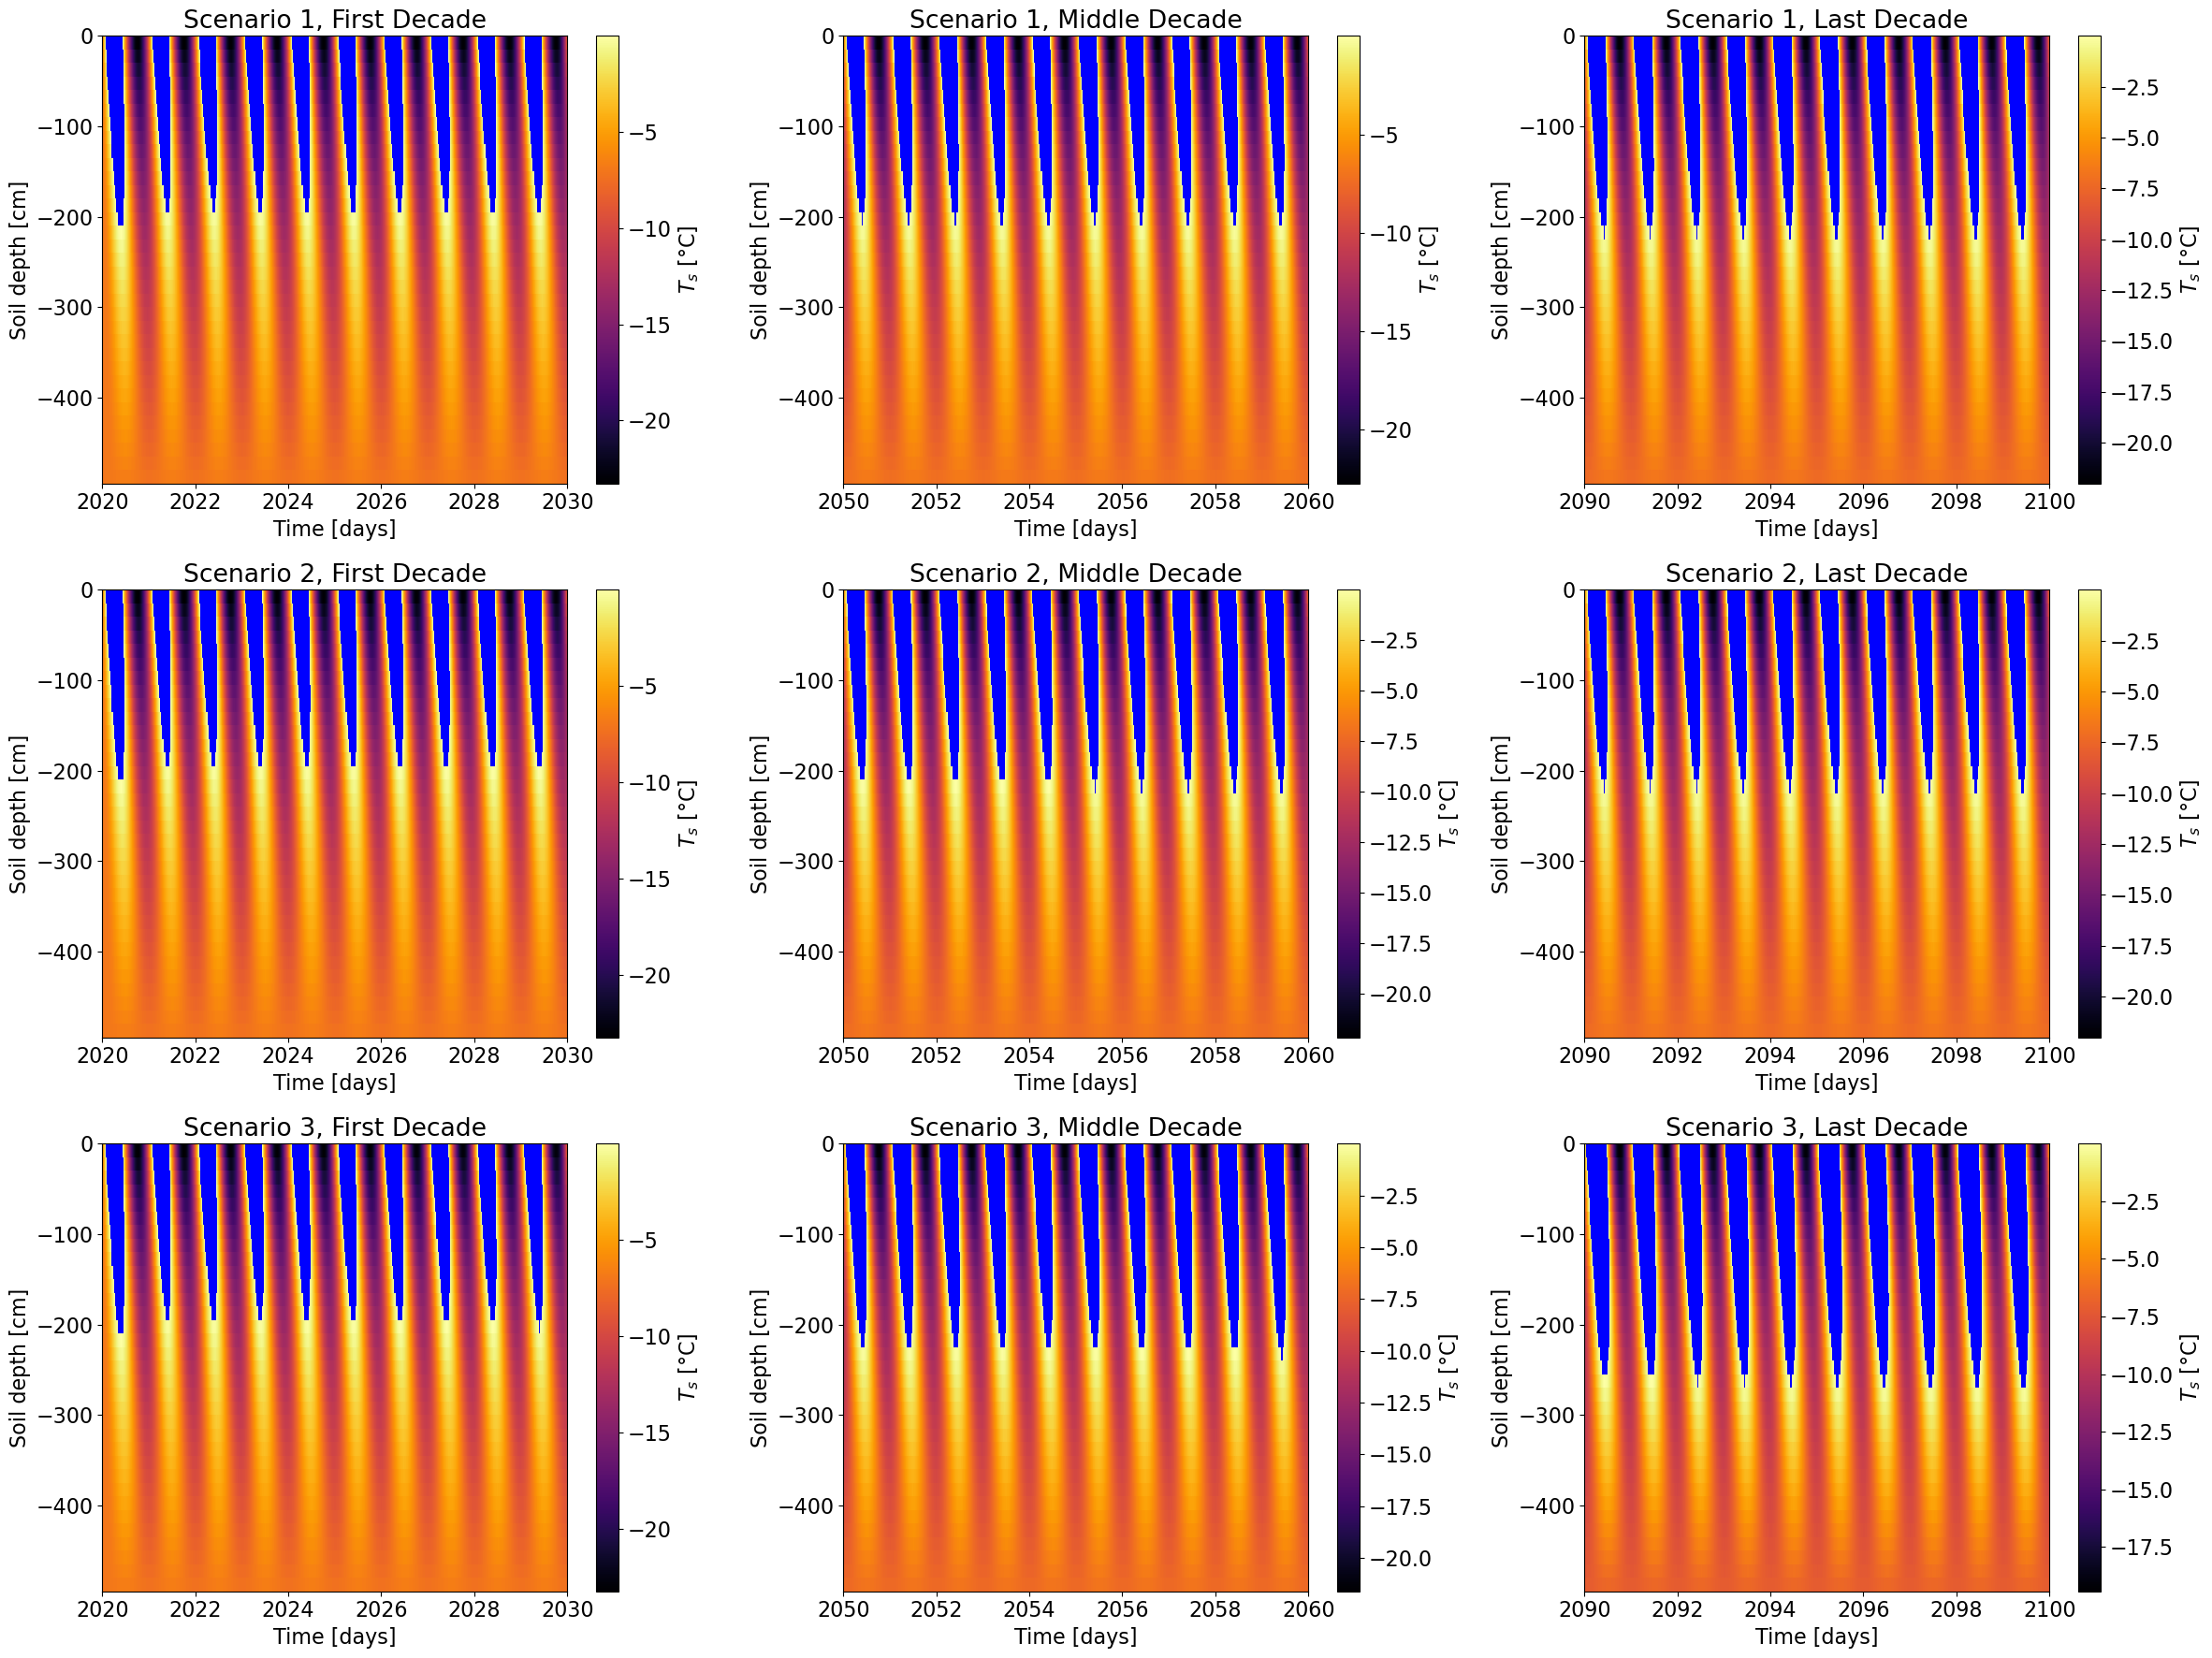

In [13]:
# Plot temperature distribution in soil with temperatures about freezing masked in order to see the active soil layer. 
# Plot the for the three scenarios (rows) and the first, middle, and final decades (columns).

t_m10 = t[43800:58401]         # Defines range of t index values for desired decade, 2050-2060
t3,z3 = np.meshgrid(t_m10,z)   # Creates meshgrid of 2050-2060 data for plotting

plt.figure(figsize = (24,18))
plt.rcParams.update({'font.size': 16})

# Mask temperatures above freezing to visualize active layer
Ts_frozen_15 = np.ma.masked_where(Ts_15>0.0,Ts_15)
Ts_frozen_30 = np.ma.masked_where(Ts_30>0.0,Ts_30)
Ts_frozen_45 = np.ma.masked_where(Ts_45>0.0,Ts_45)

# Scenario 1, 2020-2030
plt.subplot(3,3,1)
current_cmap_15 = plt.cm.get_cmap('inferno').copy()
current_cmap_15.set_bad(color='blue')
plt.pcolormesh(t1,-z1,Ts_frozen_15[:, 0:14601],cmap=current_cmap_15, shading = 'auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 1, First Decade')

# Scenario 1, 2050-2060
plt.subplot(3,3,2)
current_cmap_15 = plt.cm.get_cmap('inferno').copy()
current_cmap_15.set_bad(color='blue')
plt.pcolormesh(t3,-z3,Ts_frozen_15[:, 43800:58401],cmap=current_cmap_15, shading = 'auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 1, Middle Decade')

# Scenario 1, 2090-2100
plt.subplot(3,3,3)
current_cmap_15 = plt.cm.get_cmap('inferno').copy()
current_cmap_15.set_bad(color='blue')
plt.pcolormesh(t2,-z2,Ts_frozen_15[:, 102200:Nt+1],cmap=current_cmap_15, shading = 'auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 1, Last Decade')

# Scenario 2, 2020-2030
plt.subplot(3,3,4)
current_cmap_30 = plt.cm.get_cmap('inferno').copy()
current_cmap_30.set_bad(color='blue')
plt.pcolormesh(t1,-z1,Ts_frozen_30[:, 0:14601],cmap=current_cmap_30, shading = 'auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 2, First Decade')

# Scenario 2, 2050-2060
plt.subplot(3,3,5)
current_cmap_30 = plt.cm.get_cmap('inferno').copy()
current_cmap_30.set_bad(color='blue')
plt.pcolormesh(t3,-z3,Ts_frozen_30[:, 43800:58401],cmap=current_cmap_30, shading = 'auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 2, Middle Decade')

# Scenario 2, 2090-2100
plt.subplot(3,3,6)
current_cmap_30 = plt.cm.get_cmap('inferno').copy()
current_cmap_30.set_bad(color='blue')
plt.pcolormesh(t2,-z2,Ts_frozen_15[:, 102200:Nt+1],cmap=current_cmap_30, shading = 'auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 2, Last Decade')

# Scenario 3, 2020-2030
plt.subplot(3,3,7)
current_cmap_45 = plt.cm.get_cmap('inferno').copy()
current_cmap_45.set_bad(color='blue')
plt.pcolormesh(t1,-z1,Ts_frozen_45[:, 0:14601],cmap=current_cmap_45, shading = 'auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 3, First Decade')

# Scenario 3, 2050-2060
plt.subplot(3,3,8)
current_cmap_45 = plt.cm.get_cmap('inferno').copy()
current_cmap_45.set_bad(color='blue')
plt.pcolormesh(t3,-z3,Ts_frozen_45[:, 43800:58401],cmap=current_cmap_45, shading = 'auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 3, Middle Decade')

# Scenario 3, 2090-2100
plt.subplot(3,3,9)
current_cmap_45 = plt.cm.get_cmap('inferno').copy()
current_cmap_45.set_bad(color='blue')
plt.pcolormesh(t2,-z2,Ts_frozen_45[:, 102200:Nt+1],cmap=current_cmap_45, shading = 'auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 3, Last Decade')

plt.tight_layout()
plt.show()

|***Approximate Depth <br /> of Active Layer***|2020-2030|2050-2060|2090-2100|
|:-:|:-:|:-:|:-:|
**ΔT = 1.5 ∘C**|  190   |  205   |  220   |\n
**ΔT = 3.0 ∘C**|  190   |  210   |  230   |\n
**ΔT = 4.5 ∘C**|  190   |  220   |  270   |\n